This project was led by mgr inż. Dominik Pieczyński.

# Purpose of the project
The purpose of the project is to prepare a skull stripping method on T1 magnetic resonance imaging (MRI) images of the head. This method should extract the entire area occupied by the brain proper from the patient's raw scan, excluding bones, other soft tissues, etc.

![](https://www.researchgate.net/profile/Dario_Pompili/publication/309402865/figure/fig1/AS:420915604148224@1477365508110/Skull-stripping-steps-A-input-images-B-brain-contouring-and-C-removal-of.png)



Installing needed packages for reading and writing neuroimaging file formats

In [1]:
!pip install --upgrade nibabel

     |████████████████████████████████| 3.3MB 20.8MB/s 
  Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [2]:
!pip install --upgrade nibabel

Requirement already up-to-date: nibabel in /usr/local/lib/python3.6/dist-packages (3.2.1)


Downloading the dataset

In [3]:
!wget "https://putpoznanpl-my.sharepoint.com/:u:/g/personal/dominik_pieczynski_put_poznan_pl/EWIZ_xm8wXpMjQDgF2VQ1csB4QuHPKoj5vDpj6CQi9p-AA?e=yQr6fn&download=1" -O public.zip
!unzip -q public.zip
!rm public.zip

--2021-02-05 19:07:58--  https://putpoznanpl-my.sharepoint.com/:u:/g/personal/dominik_pieczynski_put_poznan_pl/EWIZ_xm8wXpMjQDgF2VQ1csB4QuHPKoj5vDpj6CQi9p-AA?e=yQr6fn&download=1
Resolving putpoznanpl-my.sharepoint.com (putpoznanpl-my.sharepoint.com)... 13.107.136.9
Connecting to putpoznanpl-my.sharepoint.com (putpoznanpl-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dominik_pieczynski_put_poznan_pl/Documents/Public.zip?originalPath=aHR0cHM6Ly9wdXRwb3puYW5wbC1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb21pbmlrX3BpZWN6eW5za2lfcHV0X3Bvem5hbl9wbC9FV0laX3htOHdYcE1qUURnRjJWUTFjc0I0UXVIUEtvajV2RHBqNkNRaTlwLUFBP3J0aW1lPXBjX2VXUW5LMkVn [following]
--2021-02-05 19:07:58--  https://putpoznanpl-my.sharepoint.com/personal/dominik_pieczynski_put_poznan_pl/Documents/Public.zip?originalPath=aHR0cHM6Ly9wdXRwb3puYW5wbC1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb21pbmlrX3BpZWN6eW5za2lfcHV0X3Bvem5hbl9wbC9FV0laX3htOHdYcE1qUURnR

In [ ]:
!ls FirstDataset/train

Here is the example code to download and unpack loaded data into three dimensional matrix. Additionally, there is function responsible for visualization middle slices in each of the three axes of the matrix.

In [5]:
import numpy as np
import nibabel as nib

from typing import Tuple, List
from pathlib import Path


def load_raw_volume(path: Path) -> Tuple[np.ndarray, np.ndarray]:
  data: nib.Nifti1Image = nib.load(str(path))
  data = nib.as_closest_canonical(data)
  raw_data = data.get_fdata(caching='unchanged', dtype=np.float32)
  return raw_data, data.affine


def load_labels_volume(path: Path) -> np.ndarray:
  return load_raw_volume(path)[0].astype(np.uint8)


def save_labels(data: np.ndarray, affine: np.ndarray, path: Path):
  nib.save(nib.Nifti1Image(data, affine), str(path))


def show_slices(slices: List[np.ndarray]):
   fig, axes = plt.subplots(1, len(slices))
   for i, data_slice in enumerate(slices):
       axes[i].imshow(data_slice.T, cmap="gray", origin="lower")

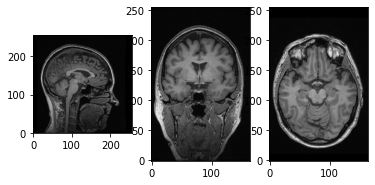

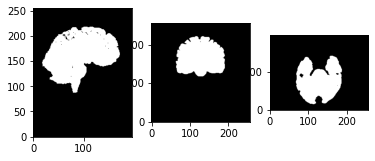

In [6]:
import matplotlib.pyplot as plt

# Zmienna affine zawiera macierz, która będzie potrzebna przy zapisie predykcji do pliku
raw_volume, affine = load_raw_volume('/content/FirstDataset/train/e66ce7e96b277d7d1b8835e5d2c94cd6.nii.gz')
mask_volume = load_labels_volume('/content/FirstDataset/train/011e40c2b1d3c9bb53bd9e5a7efd04ba_mask.nii.gz')

show_slices([raw_volume[raw_volume.shape[0] // 2], # Środkowy slice 2D w osi x
             raw_volume[:, raw_volume.shape[1] // 2], # Środkowy slice 2D w osi y
             raw_volume[:, :, raw_volume.shape[2] // 2]]) # Środkowy slice 2D w osi z

show_slices([mask_volume[mask_volume.shape[0] // 2], # Środkowy slice 2D w osi x
             mask_volume[:, mask_volume.shape[1] // 2], # Środkowy slice 2D w osi y
             mask_volume[:, :, mask_volume.shape[2] // 2]]) # Środkowy slice 2D w osi z

In [7]:
first_dataset_path = Path('/content/FirstDataset/train')
second_dataset_path = Path('/content/SecondDataset/train')

In [ ]:
# Sprawdźmy rozmiar wokseli

for scan_path in first_dataset_path.iterdir():
  if scan_path.name.endswith('mask.nii.gz'):
    print(nib.load(str(scan_path)).header.get_zooms())

print()

for scan_path in second_dataset_path.iterdir():
  print(nib.load(str(scan_path / 'T1w.nii.gz')).header.get_zooms())


# Extract masks and images from datasets

As you can see the datasets have a different folder structure, so we need to iterate through elements and extract images and labels.

In [8]:
# First dataset
first_dataset_path = Path('/content/FirstDataset/train')

X_first = []
y_first = []
for scan_path in sorted(first_dataset_path.iterdir()):
  if scan_path.name.endswith('mask.nii.gz'):
    y_first.append(scan_path)
  else:
    X_first.append(scan_path)

In [9]:
# Second Dataset
second_dataset_path = Path('/content/SecondDataset/train')

X_second = []
y_second = []
for scan_path in sorted(second_dataset_path.iterdir()):
  X_second.append(scan_path/'T1w.nii.gz')
  y_second.append(scan_path/'mask.nii.gz')

In [ ]:
# Check the length of images and labels

print(len(X_first))
print(len(y_first))
print(len(X_second))
print(len(y_second))

287
287
100
100


In [ ]:
# Split the datasets on valid and train

from sklearn.model_selection import train_test_split

X_train_first, X_valid_first, y_train_first, y_valid_first = train_test_split(X_first, y_first, train_size=0.8, random_state=42) # split dataset into train and valid
X_train_second, X_valid_second, y_train_second, y_valid_second = train_test_split(X_second, y_second, train_size=0.8, random_state=42) # split dataset into train and valid

In [ ]:
# Check the length of train/valid images and train/valid labels

print(len(X_train_first))
print(len(X_valid_first))
print("-----")
print(len(y_train_first))
print(len(y_valid_first))
print("second")

print(len(X_train_second))
print(len(X_valid_second))
print("---")
print(len(y_train_second))
print(len(y_valid_second))

In [ ]:
# Merge two datasets

X_train = X_train_first + X_train_second
X_valid = X_valid_first + X_valid_second
y_train = y_train_first + y_train_second
y_valid = y_valid_first + y_valid_second

In [ ]:
# Check the length of train/valid images and train/valid labels

print(len(X_train))
print(len(X_valid))
print(len(y_train))
print(len(y_valid))

In [ ]:
# Create folders in the structure needed for the generators used below

! mkdir /content/data_x
! mkdir /content/data_x/train
! mkdir /content/data_x/valid

! mkdir /content/data_x/train/train_images
! mkdir /content/data_x/train/train_images/train_images

! mkdir /content/data_x/train/train_labels
! mkdir /content/data_x/train/train_labels/train_labels

! mkdir /content/data_x/valid/valid_images
! mkdir /content/data_x/valid/valid_images/valid_images

! mkdir /content/data_x/valid/valid_labels
! mkdir /content/data_x/valid/valid_labels/valid_labels

# Convert images to png format

In [ ]:
import pathlib
import cv2

image = 0
mask = 0

images_dir = '/content/data_x/train/train_images/train_images/'
masks_dir = '/content/data_x/train/train_labels/train_labels/'


for X_path, label_path in zip(X_train, y_train):
  
  # Load volume and normalize it to [0:1]
  raw_volume, affine = load_raw_volume(X_path)
  raw_volume = (raw_volume - np.min(raw_volume)) / (np.max(raw_volume) - np.min(raw_volume))
  im_x_size, im_y_size, im_z_size = raw_volume.shape

  # Masks are already normalized to [0:1]
  mask_volume = load_labels_volume(label_path)
  mask_x_size, mask_y_size, mask_z_size = mask_volume.shape

  mask += 1
  image += 1
  count = 0

  # Iterate through axis x
  for img_index, mask_index in zip(range(im_x_size), range(mask_x_size)):

    img_slice = raw_volume[img_index]
    mask_slice = mask_volume[mask_index]
    count += 1

    mask_dir = masks_dir + 'mask' + str(mask)  + '_x00' + str(count) +'.png'
    image_dir = images_dir + 'image' + str(image) + '_x00' + str(count) +'.png'
    
    # Save labels in range [0:1]
    cv2.imwrite(mask_dir, mask_slice)

    # Save images in range [0:255]
    cv2.imwrite(image_dir, img_slice * 255)


In [ ]:
#VALID
import pathlib
import cv2

image = 0
mask = 0

images_dir = '/content/data_x/valid/valid_images/valid_images/'
masks_dir = '/content/data_x/valid/valid_labels/valid_labels/'


for X_path, label_path in zip(X_valid, y_valid):

  # Load volume and normalize it to [0:1]
  raw_volume, affine = load_raw_volume(X_path)
  raw_volume = (raw_volume - np.min(raw_volume)) / (np.max(raw_volume) - np.min(raw_volume))
  im_x_size, im_y_size, im_z_size = raw_volume.shape

  # Masks are already normalized to [0:1]
  mask_volume = load_labels_volume(label_path)
  mask_x_size, mask_y_size, mask_z_size = mask_volume.shape

  mask += 1
  image += 1
  count = 0

  # Iterate through axis x
  for img_index, mask_index in zip(range(im_x_size), range(mask_x_size)):

    img_slice = raw_volume[img_index]
    mask_slice = mask_volume[mask_index]
    count += 1

    mask_dir = masks_dir + 'mask' + str(mask)  + '_x00' + str(count) +'.png'
    image_dir = images_dir + 'image' + str(image) + '_x00' + str(count) +'.png'
    
    # Save labels in range [0:1]
    cv2.imwrite(mask_dir, mask_slice)

    # Save images in range [0:255]
    cv2.imwrite(image_dir, img_slice * 255)

# Saing dataset on drive in order to prevent losing the converted images and masks

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Zip folder
!zip -r train.zip /content/data_x

In [ ]:
# Move zip folder on your drive
! mv /content/dataset.zip /content/drive/MyDrive

In [ ]:
# Check the files in folder if you want to be sure that your paths aren't empty

import os
list = os.listdir('/content/data_x/valid/valid_labels/valid_labels') # dir is your directory path
number_files = len(list)
number_files

15620

# Prepare data for training


Here is the example code if you lost your temporary data on colab and want to upload converted data from your drive.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!unzip -q "/content/drive/MyDrive/zpo_dataset/dataset.zip" # Path with converted images to png

# Downloading test dataset

In [ ]:
from pathlib import Path

predictions_base_path = Path('/content/Predictions')
first_dataset_predictions_path = predictions_base_path / 'first'
second_dataset_predictions_path = predictions_base_path / 'second'

first_dataset_predictions_path.mkdir(exist_ok=True, parents=True)
second_dataset_predictions_path.mkdir(exist_ok=True, parents=True)

In [13]:
import tensorflow as tf

datagen_params = dict(horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.1)

images_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1 / 255,
    **datagen_params  # rozpakowanie słownika wyżej, zapobiega to duplikacji kodu
)

masks_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
     **datagen_params
)

batch_size = 64
validation_batch_size = 64

train_images_generator = images_datagen.flow_from_directory(
    "/content/content/data_x/train/train_images/",
    target_size=(128, 128),
    batch_size=batch_size,
    seed=42,
    interpolation='bilinear',
    class_mode=None,
)

train_masks_generator = masks_datagen.flow_from_directory(
    "/content/content/data_x/train/train_labels/",
    target_size=(128, 128),
    batch_size=batch_size,
    seed=42,
    class_mode=None,  
    interpolation='bilinear',
    color_mode='grayscale'    
)

val_images_generator = images_datagen.flow_from_directory(
    "/content/content/data_x/valid/valid_images/",
    target_size=(128, 128),
    batch_size=validation_batch_size,
    seed=42,
    interpolation='bilinear',
    class_mode=None,    
)

val_masks_generator = masks_datagen.flow_from_directory(
    "/content/content/data_x/valid/valid_labels/",
    target_size=(128, 128),
    batch_size=validation_batch_size,
    seed=42,
    class_mode=None,
    interpolation='bilinear',
    color_mode='grayscale' 
)


train_combined_generator = zip(train_images_generator, train_masks_generator)
val_combined_generator = zip(val_images_generator, val_masks_generator)

Found 61595 images belonging to 1 classes.
Found 61595 images belonging to 1 classes.
Found 15620 images belonging to 1 classes.
Found 15620 images belonging to 1 classes.


(128, 128, 3)
0.0
0.5008892
(128, 128)
0.0
1.0


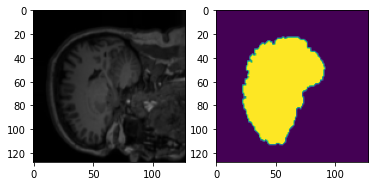

In [14]:
import matplotlib.pyplot as plt
import numpy as np

images, masks = next(train_combined_generator)

fig = plt.figure()
fig.add_subplot(1, 2, 1)
print(images[0].shape)
print(np.min(images[0]))
print(np.max(images[0]))

plt.imshow(images[0])

fig.add_subplot(1, 2, 2)

print(masks[0].squeeze().shape)
print(np.min(masks[0]))
print(np.max(masks[0]))

plt.imshow(masks[0].squeeze())

In [15]:
from tensorflow import keras

model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(128, 128, 3)),
  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),

  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),

  keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),

  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),

  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.UpSampling2D(),

  keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.UpSampling2D(),

  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.UpSampling2D(),

  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.UpSampling2D(),

  keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation="sigmoid")
  
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 256)     7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        7

In [ ]:
from keras import backend as K

# lepsza dokładność, to dąży do 1
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

# dąży do 0 - im bliżej zera, tym lepsze dopasowanie
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# wykorzystać jako loss = diec_coef_loss f
# wykorzystać jako metrykę metrics = dice_coef

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-3),
    loss=dice_coef_loss,
    metrics=[dice_coef]
)

In [ ]:
training_samples = train_images_generator.n
validation_samples = val_images_generator.n

batch_size = 128
validation_batch_size = 256

model.fit(
    train_combined_generator,
    steps_per_epoch=training_samples // batch_size,
    validation_data=val_combined_generator,
    validation_steps = validation_samples // validation_batch_size,
    epochs=5,
    verbose=1)

#Saving model

In [ ]:
# Save the model
model.save('my_model.h5')

In [ ]:
# Copy model on your drive
! cp /content/my_model.h5 /content/drive/MyDrive/zpo_dataset

In [ ]:
# Load model from your drive (remember that you have to mount your drive first)
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

model = load_model("/content/drive/MyDrive/zpo_dataset/my_model.h5", compile=False)

#Creating predictions for your test dataset

In [ ]:
!rm -rf /content/Predictions.zip

In [ ]:
first_dataset_test_path = Path('/content/FirstDataset/test')
second_dataset_test_path = Path('/content/SecondDataset/test')

import cv2
import matplotlib.pyplot as plt


for scan_path in first_dataset_test_path.iterdir():

  # Load volume and normalize it to [0:1]
  data, affine = load_raw_volume(scan_path)
  data = (data - np.min(data)) / (np.max(data) - np.min(data))

  labels = np.zeros(data.shape, dtype=np.uint8)
  x_size, y_size, z_size = data.shape

  for x_index in range(x_size):
    data_slice = data[x_index, :, :]
    data_slice_size = data_slice.shape

    # Convert data into input images to the neural network
    data_slice = cv2.resize(data_slice, (128, 128)).astype(np.float32) 
    data_slice = np.stack((data_slice,)*3, axis=-1)
    data_slice = data_slice[np.newaxis, :]

    prediction = model.predict(data_slice)
    prediction[prediction > 0.3] = 1
    prediction[prediction < 0.3] = 0

    prediction = cv2.resize(prediction.squeeze(), data_slice_size[::-1])
    labels[x_index, :, :] = prediction[:,:]

  save_labels(labels, affine, first_dataset_predictions_path / scan_path.name)

for scan_path in second_dataset_test_path.iterdir():
  
  # Load volume and normalize it to [0:1]
  data, affine = load_raw_volume(scan_path / 'T1w.nii.gz')
  data = (data - np.min(data)) / (np.max(data) - np.min(data))

  labels = np.zeros(data.shape, dtype=np.uint8)
  x_size, y_size, z_size = data.shape

  for x_index in range(x_size):
    data_slice = data[x_index, :, :]
    data_slice_size = data_slice.shape

    # Convert data into input images to the neural network
    data_slice = cv2.resize(data_slice, (128, 128)).astype(np.float32) 
    data_slice = np.stack((data_slice,)*3, axis=-1)
    data_slice = data_slice[np.newaxis, :]

    prediction = model.predict(data_slice)
    prediction[prediction > 0.3] = 1
    prediction[prediction < 0.3] = 0

    prediction = cv2.resize(prediction.squeeze(), data_slice_size[::-1])
    labels[x_index, :, :] = prediction[:,:]
  
  save_labels(labels, affine, second_dataset_predictions_path / f'{scan_path.name}.nii.gz')

Convert to zip and save folder Predictions in order to prevent losing temporary data from colab.

In [ ]:
# Zip folder
!zip -r Predictions.zip /content/Predictions

In [ ]:
# Move folder Predictions to your drive
! mv /content/Predictions.zip /content/drive/MyDrive

Upload folder Predictions from your drive if you lost your temporary data from colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q "/content/Aleksandra_Przybylska_Predictions.zip"

In [ ]:
!mv /content/content/Predictions /content/

In [ ]:
! rm -rf /content/content

In [ ]:
from pathlib import Path
import nibabel as nib

predictions_base_path = Path('/content/Predictions')
first_dataset_predictions_path = predictions_base_path / 'first'
second_dataset_predictions_path = predictions_base_path / 'second'

# Check your predictions

In [ ]:
import requests
import zlib
import numpy as np


values = []

for dataset_predictions_path in (first_dataset_predictions_path, second_dataset_predictions_path):
  for prediction_path in dataset_predictions_path.iterdir():
    prediction_name = prediction_path.name[:-7]  # Usuwanie '.nii.gz' z nazwy pliku
    prediction = nib.load(str(prediction_path))

    response = requests.post(f'https://zpo.dpieczynski.pl/{prediction_name}', data=zlib.compress(prediction.to_bytes()))
    if response.status_code == 200:
        print(dataset_predictions_path.name, prediction_path.name, response.json())
        values.append(response.json()['dice'])
    else:
        print(f'Error processing prediction {dataset_predictions_path.name}/{prediction_name}: {response.text}')

# Count mean value of your metric
print("Mean", np.mean(values))